<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/14_4_anchor_boxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.2 MB/s eta 0:00:00


## 14.4 Anchor Boxes

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

### 14.4.1 Generating Multiple Anchor Boxes

In [3]:
def multibox_prior(data, sizes, ratios):
  in_height, in_width = data.shape[-2:]
  device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
  boxes_per_pixel = (num_sizes + num_ratios - 1)
  size_tensor = torch.tensor(sizes, device=device)
  ratio_tensor = torch.tensor(ratios, device=device)

  offset_h, offset_w = 0.5, 0.5
  steps_h = 1.0 / in_height
  steps_w = 1.0 / in_width

  center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
  center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
  shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
  shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

  w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                 sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                 * in_height / in_width
  h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                 sizes[0] / torch.sqrt(ratio_tensor[1:])))
  anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                     in_height * in_width, 1) / 2
  
  out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                         dim=1).repeat_interleave(boxes_per_pixel, dim=0)
  output = out_grid + anchor_manipulations
  return output.unsqueeze(0)

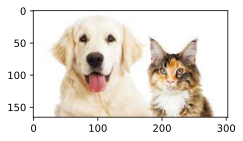

In [6]:
from PIL import Image
import torchvision.transforms as T


img = Image.open('catdog.jpg')
d2l.plt.imshow(img)
aug = T.Compose([T.Resize((561, 728)),
                 T.ToTensor()])
img = aug(img)
h, w = img.shape[1:]

In [7]:
print(h, w)
X = torch.rand(size=(1, 3, h, w)) # COnstruct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [8]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In [9]:
def show_bboxes(axes, bboxes, labels=None, colors=None):

  def make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = make_list(labels)
  colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i],
                va='center', ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

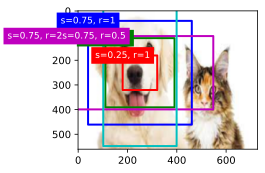

In [10]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img.permute(1, 2, 0).detach().numpy())
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2'
            's=0.75, r=0.5'])

### 14.4.2 Intersection over Union (IoU)

In [11]:
def box_iou(boxes1, boxes2):
  """Compute pairwise IoU across two lists of anchor or bounding boxes."""
  box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                            (boxes[:, 3] - boxes[:, 1]))
  areas1 = box_area(boxes1)
  areas2 = box_area(boxes2)

  inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
  inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, :2])
  inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)

  inter_areas = inters[:, :, 0] * inters[:, :, 1]
  union_areas = areas1[:, None] + areas2 - inter_areas
  return inter_areas / union_areas

### 14.4.3 Labelling Anchor Boxes in Training Data

#### Assigning Ground-Truth Bounding Boxes to Anchor Boxes

In [12]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
  num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]

  jaccard = box_iou(anchors, ground_truth)
  anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                device=device)
  
  max_ious, indices = torch.max(jaccard, dim=1)
  anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
  box_j = indices[max_ious >= iou_threshold]
  col_discard = torch.full((num_anchors,), -1)
  row_discard = torch.full((num_gt_boxes,), -1)

  for _ in range(num_gt_boxes):
    max_idx = torch.argmax(jaccard)
    box_idx = (max_idx % num_gt_boxes).long()
    anc_idx = (max_idx / num_gt_boxes).long()
    anchors_bbox_map[anc_idx] = box_idx
    jaccard[:, box_idx] = col_discard
    jaccard[anc_idx, :] = row_discard
  return anchors_bbox_map


#### Labelling Classes and Objects

In [13]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
  c_anc = d2l.box_corner_to_center(anchors)
  c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
  offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
  offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
  offset = torch.cat([offset_xy, offset_wh], axis=1)
  return offset

In [21]:
def multibox_target(anchors, labels):
  batch_size, anchors = labels.shape[0], anchors.squeeze(0)
  batch_offset, batch_mask, batch_class_labels = [], [], []
  device, num_anchors = anchors.device, anchors.shape[0]
  for i in range(batch_size):
    label = labels[i, :, :]
    anchors_bbox_map = assign_anchor_to_bbox(
        label[:, 1:], anchors, device)
    bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)

    class_labels = torch.zeros(num_anchors, dtype=torch.long,
                               device=device)
    assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                              device=device)
    
    indices_true = torch.nonzero(anchors_bbox_map >= 0)
    bb_idx = anchors_bbox_map[indices_true]
    class_labels[indices_true] = label[bb_idx, 0].long() + 1
    assigned_bb[indices_true] = label[bb_idx, 1:]

    offset = offset_boxes(anchors, assigned_bb) * bbox_mask
    batch_offset.append(offset.reshape(-1))
    batch_mask.append(bbox_mask.reshape(-1))
    batch_class_labels.append(class_labels)
  bbox_offset = torch.stack(batch_offset)
  bbox_mask = torch.stack(batch_mask)
  class_labels = torch.stack(batch_class_labels)
  return (bbox_offset, bbox_mask, class_labels)

#### An Example

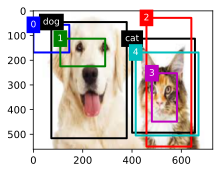

In [22]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                       [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                       [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img.permute(1, 2, 0).detach().numpy())
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'],'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [23]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

In [24]:
labels[2]

tensor([[1, 2, 0, 0, 0]])

In [25]:
labels[1]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [26]:
labels[0]

tensor([[10.50, 15.00,  3.71,  7.18, 18.00, 12.00,  1.68,  6.12, -0.00, -0.00,
         -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00]])